In [51]:
import numpy as np
import matplotlib.pyplot as plt

Orchestative Exploration Algorithm

In [52]:
# 0 indexing for arms
t = 1
T = 10000
N = 7                                                    # Number of plays per round
K = 9                                                    # Number of arms
Yt  = []                                                 # Arms deserving UE
St = np.arange(0, N, dtype=int)                          # set of Empirically optimal arms for IE
St_bar = []
Lt = N-1                                                 # Empirically least favoured arm in St (least mean arm in St)
Lt2 = N-1
mu_hat_t = np.zeros(K, dtype=float)                      # Estimate of mean of arm rewards at time t when PIE used
v_hat_t = np.zeros(K, dtype=float)                       # Estimate of mean of arm rewards at time t when PUE used
ut = np.zeros(K, dtype=float)                            # UCB
tau_hat_t = np.ones(K, dtype=int)                        # No. of times such that assigned pulls < capacity (lower limit)
i_hat_t = np.ones(K, dtype=int)                          # No. of times such that assigned pulls > capacity |(upper limit)
pulls_t = tau_hat_t + i_hat_t                            # Total no. of pulls till time t
m_lt = np.ones(K, dtype=int)                             # Lower estimate of capacity value
m_ut = N*np.ones(K, dtype=int)                           # Upper estimate of capacity value
delta = 2/T
M = 8
reward_total = np.zeros(K, dtype=float)                  # Total reward per arm
regret_step1 = np.zeros(T, dtype=float)
regret_step2 = np.zeros(T, dtype=float)
regret_step3 = np.zeros(T, dtype=float)
capacity_error1 = np.zeros(T, dtype=float) 
capacity_error2 = np.zeros(T, dtype=float) 
capacity_error3 = np.zeros(T, dtype=float) 
reward_step_t = np.zeros(K, dtype = float)

The Oracle function takes mean and capacity as input and assigns optimum plays to the arms

In [53]:
def Oracle(mu_hat, mt):
    idx_descending = np.argsort(mu_hat)[::-1]           # Here we are sorting the indices in descending order of means

    # We now need to check the capacity for the indices obtained above
    at = np.zeros(K, dtype=int)
    play_rem = N
    for i in (idx_descending):
        at[i] = min(mt[i], play_rem)
        play_rem = max(play_rem - at[i], 0)
        if (play_rem == 0):
            break

    return at

Class theOracle has the access to original mean and capacities of the arms according to which it assigns gaussian rewards to the play

In [54]:
class theOracle:
    def __init__(self, K):
        self.K = K
        self.mu = np.ones(self.K, dtype=float)
        self.var = 0.5
        self.m = np.ones(self.K, dtype=int)

        self.mu = [5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1]
        self.m = [2, 4, 3, 3, 2, 1, 1, 1, 1]

    def play(self, at):
        # This function has access to the actual means of the arms and outputs according to that
        # That access should not be given to any other function
        # This function should be part of some class which has all the data
        reward = np.zeros(K, dtype=float)
        for k in range (K):
            reward[k] = abs(np.sum(np.random.normal(self.mu[k], self.var, min(at[k], self.m[k]))))

        return reward
    
    def optimalRewards(self):
        at_opt = Oracle(self.mu, self.m)
        reward_opt = self.play(at_opt)
        return reward_opt

    def regret(self, rewards_act):
        f_opt = np.sum(self.optimalRewards())
        f_act = np.sum(rewards_act)
        regret = f_opt - f_act
        return regret
    
    def capacity_estimate_error(self, m_lt):
        return np.sum(abs(m_lt - self.m))

In [55]:
def ut_update(tau_hat_t, mu_hat_t, t):
    ut = mu_hat_t + 2*np.sqrt((np.log(t)+4*np.log(np.log(t)+1))/tau_hat_t)
    return ut

Parsimonious Individual Exploration

In [56]:
def PIE(mu_hat_t, m_lt, tau_hat_t, reward_total, ut, p):
    ut = ut_update(tau_hat_t, mu_hat_t, t)
    at_IE = Oracle(mu_hat_t, m_lt)
    not_zero = np.count_nonzero(at_IE)
    St1 = np.nonzero(at_IE)
    St = np.asarray(St1)
    St.resize(not_zero)
    zero = K - not_zero
    St_bar = np.where(at_IE == 0)[0]
    St_bar.resize(zero)

    idx_ascending = np.argsort(mu_hat_t)
    for i in idx_ascending:
        if (np.isin(i, St)):
            Lt = i
            break
    
    Et = []
    for k in St_bar:
        if (ut[k] >= mu_hat_t[Lt]):
            Et.append(k)

    if (len(Et) > 0):
        toss = np.random.choice([0, 1], p=[1-p, p])
        if (toss):
            l = np.random.choice(Et, size=1)
            at_IE[Lt] -= 1
            at_IE[l] = 1

    reward = theGame.play(at_IE)
    reward_step_t = reward.copy()
    reward_total += reward

    ## Update values
    # Here no. of plays of an arm is equal to what we assigned
    for k in range (K):
        mu_hat_t [k] = (mu_hat_t[k]*tau_hat_t[k] + reward[k])/(tau_hat_t[k] + at_IE[k])             # given that rewards from function play are total reward of one particular arm

    tau_hat_t += at_IE
    return reward_step_t

In [57]:
def PIE2(mu_hat_t, m_lt, tau_hat_t, reward_total, ut, p):
    Lt2 = N-1
    ut = ut_update(tau_hat_t, mu_hat_t, t)
    at_IE = Oracle(mu_hat_t, m_lt)
    not_zero = np.count_nonzero(at_IE)
    St1 = np.nonzero(at_IE)
    St = np.asarray(St1)
    St.resize(not_zero)
    zero = K - not_zero
    St_bar = np.where(at_IE == 0)[0]
    St_bar.resize(zero)

    idx_ascending = np.argsort(mu_hat_t)
    for i in idx_ascending:
        ind = 0
        if (np.isin(i, St) and ind == 0):
            Lt = i
            ind += 1
        elif (np.isin(i, St) and ind == 1):
            Lt2 = i
            break
    
    Et = []
    for k in St_bar:
        if (ut[k] >= mu_hat_t[Lt]):
            Et.append(k)

    if (len(Et) > 0):
        toss = np.random.choice([0, 1], p=[1-p, p])
        if (toss):
            l = np.random.choice(Et, size=2)
            at_IE[Lt] -= 1
            # at_IE[Lt2] -= 1
            at_IE[l[0]] = 1
            at_IE[l[1]] = 1

    reward = theGame.play(at_IE)
    reward_step_t = reward.copy()
    reward_total += reward

    ## Update values
    # Here no. of plays of an arm is equal to what we assigned
    for k in range (K):
        mu_hat_t [k] = (mu_hat_t[k]*tau_hat_t[k] + reward[k])/(tau_hat_t[k] + at_IE[k])             # given that rewards from function play are total reward of one particular arm

    tau_hat_t += at_IE 
    return reward_step_t

Parsimonous United Exploration

In [58]:
def PUE(mu_hat_t, Yt, M, i_hat_t, reward_total, v_hat_t):
    mu_hat_t_prime = mu_hat_t.copy()
    for k in Yt:
        mu_hat_t_prime[k] += M
    at_UE = Oracle(mu_hat_t_prime, m_ut)
    reward = theGame.play(at_UE)
    reward_step_t = reward.copy()
    reward_total += reward

    ## Update the values
    # Here number of plays of each arm is equal to its capacity, basically m_ut, here we will consider the average by considering the increase in no. of pulls by 1
    for k in range (K):
        v_hat_t[k] = (v_hat_t[k]*i_hat_t[k] + reward[k])/(i_hat_t[k] + 1)
    i_hat_t += at_UE
    return reward_step_t
    

In [59]:
def phi(x, delta):
    return np.sqrt((1+1/x)*np.log(2*np.sqrt(x+1)/delta)/(2*x))

Algorithm

In [60]:
theGame = theOracle(K)
while (t < T):
    if t % 2 == 1 or len(Yt) == 0:
        reward_step_t =  PIE(mu_hat_t, m_lt, tau_hat_t, reward_total, ut, 0.5)
    else:
        reward_step_t = PUE(mu_hat_t, Yt, M, i_hat_t, reward_total, v_hat_t)
    ## update mlt and mut
    for k in range(K):
        if(t > 1):
            m_lt[k] = max(np.ceil(v_hat_t[k]/(mu_hat_t[k] + phi(tau_hat_t[k], delta) + phi(i_hat_t[k], delta))), 1, m_lt[k])
            m_ut[k] = min(abs(np.floor((v_hat_t[k])/(mu_hat_t[k] - phi(tau_hat_t[k], delta)) - phi(i_hat_t[k], delta))), N, m_ut[k])

    Yt = []
    for k in St:
        if (k != Lt):
            if (m_lt[k] != m_ut[k]):
                Yt.append(k)
    regret_step1[t] = theGame.regret(reward_step_t) + regret_step1[max(0, t-1)]
    capacity_error1[t] = theGame.capacity_estimate_error(m_lt) + capacity_error1[max(0, t-1)]
    t += 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


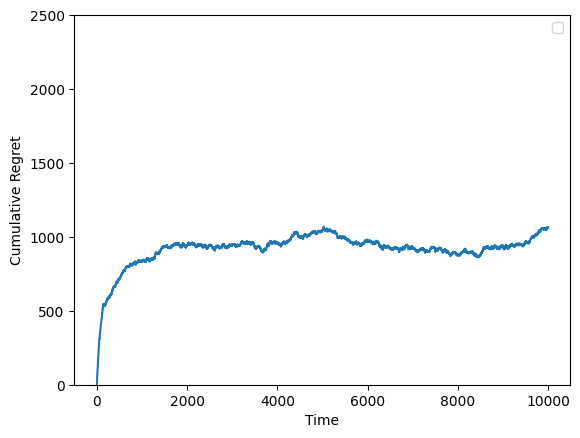

In [61]:
plt.plot(regret_step1)
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.ylim(0, 2500)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


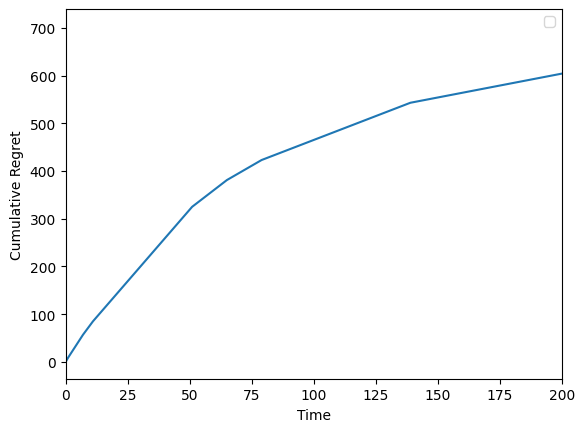

In [62]:
plt.plot(capacity_error1)
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.xlim(0, 200)
plt.show()

Modification 1: Increasing the probability of random exploration

In [67]:
t = 1
Yt  = []                                    # Arms deserving UE
St = np.arange(0, N, dtype=int)             # set of Empirically optimal arms for IE
St_bar = []
Lt = N-1                                    # Empirically least favoured arm in St (least mean arm in St)
mu_hat_t = np.zeros(K, dtype=float)           # Estimate of mean of arm rewards at time t when PIE used
v_hat_t = np.zeros(K, dtype=float)            # Estimate of mean of arm rewards at time t when PUE used
ut = np.zeros(K, dtype=float)                 # 
tau_hat_t = np.ones(K, dtype=int)           # No. of times such that assigned pulls < capacity (lower limit)
i_hat_t = np.ones(K, dtype=int)             # No. of times such that assigned pulls > capacity (upper limit)
pulls_t = tau_hat_t + i_hat_t               # Total no. of pulls till time t
m_lt = np.ones(K, dtype=int)                # Lower estimate of capacity value
m_ut = N*np.ones(K, dtype=int)              # Upper estimate of capacity value
reward_total = np.zeros(K, dtype=float)       # Total reward per arm
regret_step2 = np.zeros(T, dtype=float)
capacity_error2 = np.zeros(T, dtype=float) 
reward_step_t = np.zeros(K, dtype = float)   

In [68]:
theGame1 = theOracle(K)
while (t < T):
    if t % 2 == 1 or len(Yt) == 0:
        reward_step_t =  PIE(mu_hat_t, m_lt, tau_hat_t, reward_total, ut, 0.8)
    else:
        reward_step_t = PUE(mu_hat_t, Yt, M, i_hat_t, reward_total, v_hat_t)
    ## update mlt and mut
    for k in range(K):
        if(t > 1):
            m_lt[k] = max(np.ceil(v_hat_t[k]/(mu_hat_t[k] + phi(tau_hat_t[k], delta) + phi(i_hat_t[k], delta))), 1, m_lt[k])
            m_ut[k] = min(abs(np.floor((v_hat_t[k])/(mu_hat_t[k] - phi(tau_hat_t[k], delta)) - phi(i_hat_t[k], delta))), N, m_ut[k])

    Yt = []
    for k in St:
        if (k != Lt):
            if (m_lt[k] != m_ut[k]):
                Yt.append(k)
    regret_step2[t] = theGame1.regret(reward_step_t) + regret_step2[max(0, t-1)]
    capacity_error2[t] = theGame1.capacity_estimate_error(m_lt) + capacity_error2[max(0, t-1)]
    t += 1

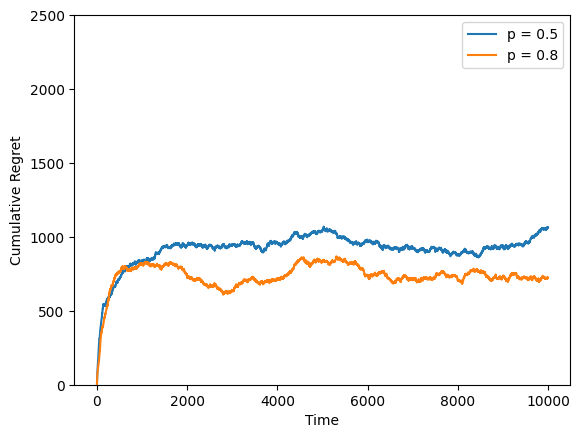

In [69]:
plt.plot(regret_step1, label = "p = 0.5")
plt.plot(regret_step2, label = "p = 0.8")
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.ylim(0, 2500)
plt.show()

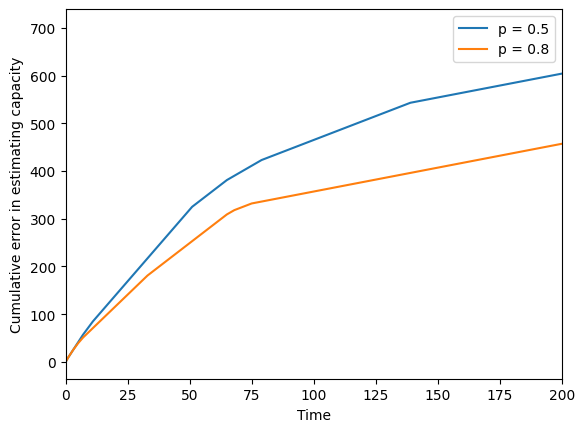

In [70]:
plt.plot(capacity_error1, label = "p = 0.5")
plt.plot(capacity_error2, label = "p = 0.8")
plt.xlabel("Time")
plt.ylabel("Cumulative error in estimating capacity")
plt.xlim(0, 200)
plt.legend()
plt.show()

Modification 2: Exporing more arms

In [71]:
t = 1
Yt  = []                                    # Arms deserving UE
St = np.arange(0, N, dtype=int)             # set of Empirically optimal arms for IE
St_bar = []
Lt = N-1                                    # Empirically least favoured arm in St (least mean arm in St)
Lt2 = N-1
mu_hat_t = np.zeros(K, dtype=float)           # Estimate of mean of arm rewards at time t when PIE used
v_hat_t = np.zeros(K, dtype=float)            # Estimate of mean of arm rewards at time t when PUE used
ut = np.zeros(K, dtype=float)                 # 
tau_hat_t = np.ones(K, dtype=int)           # No. of times such that assigned pulls < capacity (lower limit)
i_hat_t = np.ones(K, dtype=int)             # No. of times such that assigned pulls > capacity (upper limit)
pulls_t = tau_hat_t + i_hat_t               # Total no. of pulls till time t
m_lt = np.ones(K, dtype=int)                # Lower estimate of capacity value
m_ut = N*np.ones(K, dtype=int)              # Upper estimate of capacity value
reward_total = np.zeros(K, dtype=float)       # Total reward per arm
regret_step3 = np.zeros(T, dtype=float)
capacity_error3 = np.zeros(T, dtype=float) 
reward_step_t = np.zeros(K, dtype = float)

In [72]:
theGame2 = theOracle(K)
while (t < T):
    if t % 2 == 1 or len(Yt) == 0:
        reward_step_t =  PIE2(mu_hat_t, m_lt, tau_hat_t, reward_total, ut, 0.8)
    else:
        reward_step_t = PUE(mu_hat_t, Yt, M, i_hat_t, reward_total, v_hat_t)
    ## update mlt and mut
    for k in range(K):
        if(t > 1):
            m_lt[k] = max(np.ceil(v_hat_t[k]/(mu_hat_t[k] + phi(tau_hat_t[k], delta) + phi(i_hat_t[k], delta))), 1, m_lt[k])
            m_ut[k] = min(abs(np.floor((v_hat_t[k])/(mu_hat_t[k] - phi(tau_hat_t[k], delta)) - phi(i_hat_t[k], delta))), N, m_ut[k])

    Yt = []
    for k in St:
        if (k != Lt):
            if (m_lt[k] != m_ut[k]):
                Yt.append(k)
    regret_step3[t] = theGame2.regret(reward_step_t) + regret_step3[max(0, t-1)]
    capacity_error3[t] = theGame2.capacity_estimate_error(m_lt) + capacity_error3[max(0, t-1)]
    t += 1

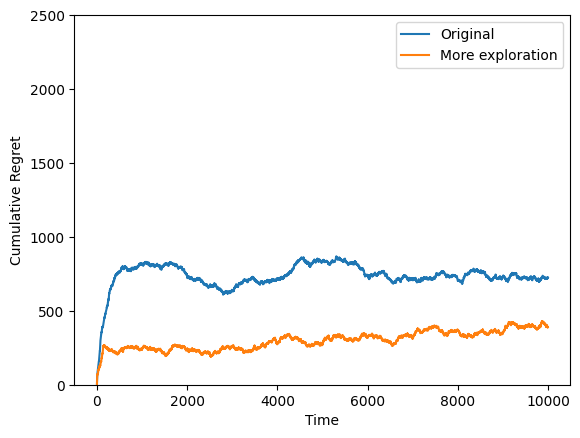

In [73]:
plt.plot(regret_step2, label = "Original")
plt.plot(regret_step3, label = "More exploration")
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.ylim(0, 2500)
plt.show()

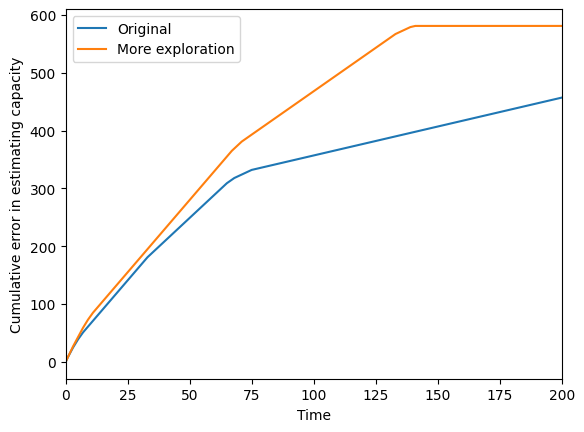

In [74]:
plt.plot(capacity_error2, label = "Original")
plt.plot(capacity_error3, label = "More exploration")
plt.xlabel("Time")
plt.ylabel("Cumulative error in estimating capacity")
plt.xlim(0, 200)
plt.legend()
plt.show()

Final results

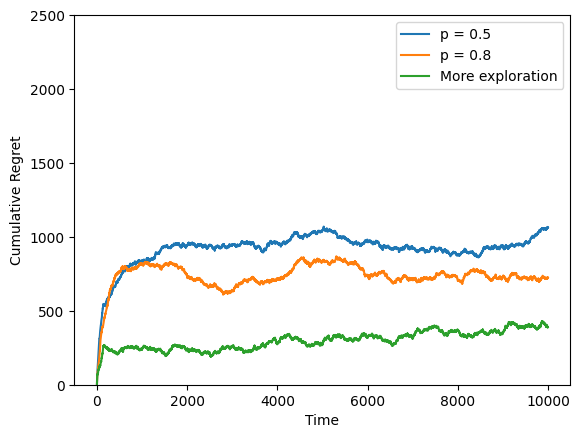

In [75]:
plt.plot(regret_step1, label = "p = 0.5")
plt.plot(regret_step2, label = "p = 0.8")
plt.plot(regret_step3, label = "More exploration")
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.ylim(0, 2500)
plt.show()

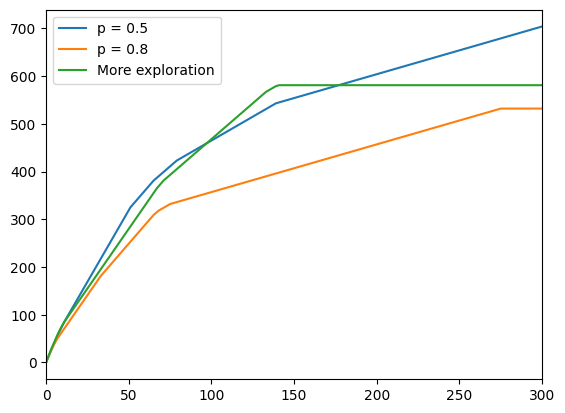

In [76]:
plt.plot(capacity_error1, label = "p = 0.5")
plt.plot(capacity_error2, label = "p = 0.8")
plt.plot(capacity_error3, label = "More exploration")
plt.xlim(0, 300)
plt.legend()
plt.show()